| **Authors**                | **Student Number** |
|----------------------------|---------------------|
| Jakob Schledermann Winkel  | s213555             |
| Frederik Bøttger-Roth      | s153277             |
| Nima Jalili                | s194825             |
| Julius Olander             | s203225             |

# 0. Instructions

Make sure that all of the data files are in the same folder as the notebook, which includes:
* comptools_spotify_data
* lyrics
* signature_matrix-q2k20000.npy

The data scraping are included in the notebook, but it is advised to not run these blocks as they are very time consuming. It is mentioned clearly when where you can start using the above mentioned data provided.

To skip spotify data collection go to chapter 1.5


# 1. Spotify data collection
For this project we are using the Spotify API to collect song data for a recommendation system. In the following section, we will make a request to the API and retrieve the song data, consisting of 11 different playlists from different genres.

## 1.1 Imports

In [15]:
import requests
import base64
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
sns.set_style("darkgrid")

## 1.2 Credentials and authentication
We retrieve our access token to the Spotify API, by using a unique *client_id* and *client_secret*. These are retrieved by creating an app at https://developer.spotify.com/documentation/web-api.

The function below takes our client_id and client_secret as inputs and outputs the access token needed for fetching song data.

In [6]:
client_id = 'aa0207fb75aa45eaba50df2d8402a464'
client_secret = '42e3594f4e86467a89e27bc2f1d32977'

def get_access_token(client_id, client_secret):
    
    # authentication
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode())

    # set up the token URL and headers
    token_url = "https://accounts.spotify.com/api/token"
    token_headers = {
        "Authorization": f"Basic {client_creds_b64.decode()}"  # Basic <base64 encoded client_id:client_secret>
    }
    token_data = {
        "grant_type": "client_credentials"
    }

    # request to get the access token
    r = requests.post(token_url, headers=token_headers, data=token_data)
    token_response_data = r.json()

    return token_response_data['access_token']

access_token = get_access_token(client_id, client_secret)

## 1.3 Fetching song data

Now we can retrieve song data through the API. First we create a function which retrieves all tracks in a given Spotify playlist, by providing the playlist URL and our access token.

In [2]:
def get_playlist_tracks(playlist_URI, access_token):
    endpoint = f"https://api.spotify.com/v1/playlists/{playlist_URI}/tracks"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(endpoint, headers=headers)
    tracks_data = response.json()
    return tracks_data

Spotify also provides various song features that describe different musical attributes of a song. We want to take such features into account when builting our recommender system. We therefore define the function below, that takes a song's *track_id* along with our access token as input, and outputs the audio features for that track.

In [3]:
def get_audio_features(track_id, access_token):
    endpoint = f"https://api.spotify.com/v1/audio-features/{track_id}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(endpoint, headers=headers)
    return response.json()

### 1.3.1 Selection of genres
Now we can start collecting the data using our functions. We have decided to import songs from 11 different genres, each with 100 songs.

It should be noted that it is possible to retrieve genre data for songs, however these were often found to be comprised of long lists of every highly niche subgenre that a song artist has dabbled in (i.e. "outlaw-country", "east-coast hiphop" etc.). For the scope of this project, we wanted to keep the genres more generel, only distinguishing between genres where we though it made sense, i.e. "metal" and "death-metal" are classified as seperate genres, even though some might argue that they could both be under the umbrella term "metal" or even "rock".

The genres are selected somewhat arbitrarily, using our own domain-expertise/experience, with the goal of wanting to cover a wide variety of genres to challenge our model. In example, the genres range from "death metal" and "jazz" and "pop" and "classical". The process for gathering the genre data was:
1. Decide on which genres to include
2. For each genre, search playlists with songs of that genre on Spotify
3. Copy the link for each playlist and import the song data using the functions above

Below we define *playlists* and *genre_list* variables, that includes all the playlists and their subsequent genres used in this project.

In [5]:
playlists = ['https://open.spotify.com/playlist/37i9dQZF1DWXRqgorJj26U', # rock
            'https://open.spotify.com/playlist/37i9dQZF1DXbLJ4V4LNcKE', # christmas
            'https://open.spotify.com/playlist/6mtYuOxzl58vSGnEDtZ9uB', # pop
            'https://open.spotify.com/playlist/37i9dQZF1DWTcqUzwhNmKv', # metal
            'https://open.spotify.com/playlist/37i9dQZF1DXd9rSDyQguIk', # blues
            'https://open.spotify.com/playlist/37i9dQZF1DXbITWG1ZJKYt', # jazz
            'https://open.spotify.com/playlist/37i9dQZF1DX7SEhw42DW5b', # edm
            'https://open.spotify.com/playlist/37i9dQZF1DWWEJlAGA9gs0', # classical
            'https://open.spotify.com/playlist/27hWL3hFMwwfRiA13SWsWU', # death-metal
            'https://open.spotify.com/playlist/61HuMNlZALdDeWGJeI631D?si=377b57d351b54ce5', # hiphop
            'https://open.spotify.com/playlist/69sctJ0acuqqO1dAjcSdBj?si=0ab8e19e61fb4917' # country
]


genre_list = ['rock', 'christmas', 'pop',
              'metal', 'blues', 'jazz', 'edm',
              'classical', 'death-metal', 'hiphop','country']

We now run the functions *get_playlist_tracks* and *get_audio_features* to retrieve the song data, by looping over all the playlists and their songs. This includes some initial pre-processing of the playlist links and defining lists to use as columns for our pandas DataFrame objects.

`Note: this can take a long time to run and the API can sometimes be unstable. We recommend you import the data as a local file further below.`

In [7]:
track_names = []
artist_names = []
audio_features_list = []
release_years = []
genres = []
k = 0

# loop over all playlists
for index, playlist in enumerate(playlists):
    # split the link at "/" to only get the URI of playlist link
    playlist_URI = playlist.split("/")[-1].split("?")[0]

    genre = genre_list[k]
    tracks_data = get_playlist_tracks(playlist_URI, access_token)

    if tracks_data and 'items' in tracks_data:
        # loop over the json tracks, get the items we need and append to empty lists
        for item in tracks_data['items']:
            track = item.get('track')
            if track:
                track_names.append(track.get('name'))
                artist_id = track['artists'][0]['id']
                artist_name = track['artists'][0]['name']
                artist_names.append(artist_name)
                release_year = track['album']['release_date']
                release_years.append(release_year)
                genres.append(genre)

                # get audio features
                audio_features = get_audio_features(track['id'], access_token)
                if audio_features:
                    audio_features_list.append(audio_features)

    # make the dataframe with all tracks from lists
    track_df = pd.DataFrame({
        'track_name': track_names,
        'artist_name': artist_names,
        'genre': genres,
        'release_year': release_years
    })

    k += 1

NameError: name 'playlists' is not defined

## 1.4 Data inspection and cleansing
Now let's have a look at our track dataframe. 

In [14]:
track_df

,track_name,artist_name,genre,release_year
0,I Wanna Be Sedated - 2002 Remaster,Ramones,rock,1978-09-22
1,Highway to Hell,AC/DC,rock,1979-07-27
2,"Paint It, Black",The Rolling Stones,rock,1966-04-15
3,Everlong,Foo Fighters,rock,1997-05-20
4,Free Bird,Lynyrd Skynyrd,rock,1973-01-01
...,...,...,...,...
1039,Killin' Time,Clint Black,country,2003-09-22
1040,You Make It Easy,Saltwater Saddles,country,2023-11-13
1041,The Race Is On,Sawyer Brown,country,1989-09-13
1042,The Closer You Get,Alabama,country,1983


As we can see, we have imported a total of 1044 songs.

It looks as if the release_year column includes month and day for some entries, and only year for others. For the purpose of this project, we will just keep the year. Therefore we split the date string at "-" below.

In [16]:
track_df['release_year'] = [track.split("-")[0] for track in track_df['release_year']]

Let's have a look at the audio features.

In [17]:
audio_features_list[1]

{'danceability': 0.574,
 'energy': 0.913,
 'key': 6,
 'loudness': -4.793,
 'mode': 0,
 'speechiness': 0.133,
 'acousticness': 0.061,
 'instrumentalness': 0.00158,
 'liveness': 0.156,
 'valence': 0.423,
 'tempo': 115.728,
 'type': 'audio_features',
 'id': '2zYzyRzz6pRmhPzyfMEC8s',
 'uri': 'spotify:track:2zYzyRzz6pRmhPzyfMEC8s',
 'track_href': 'https://api.spotify.com/v1/tracks/2zYzyRzz6pRmhPzyfMEC8s',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2zYzyRzz6pRmhPzyfMEC8s',
 'duration_ms': 208400,
 'time_signature': 4}

As we can see, there are many different musical features included. In example, we have the song's "key" encoded from 0-11 over all 12 musical keys (e.g. 0=C, 1=C#, 2=D, 3=D# etc.). Also acousticness as measured on a scale of confidence from 0 to 1, where 1 is high confidence that the track is acoustic. By investigating each feature in the Spotify developer documentation (https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features), we decided upon which of the features to include. These are added to our track_df below. In addition to the audio features, we also include *release_year*, as that might add additional context to the end-user's taste in music.

In [18]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms',
            'time_signature']
audio_features_df = pd.DataFrame(audio_features_list, columns=features)
track_df = pd.concat([track_df, audio_features_df], axis=1)

Now we have our final dataframe with song data and the selected audio features.

In [19]:
track_df.head()

,track_name,artist_name,genre,release_year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,I Wanna Be Sedated - 2002 Remaster,Ramones,rock,1978,0.597,0.960,11.0,-3.989,1.0,0.0420,0.16900,0.000029,0.1050,0.937,163.017,149467.0,4.0
1,Highway to Hell,AC/DC,rock,1979,0.574,0.913,6.0,-4.793,0.0,0.1330,0.06100,0.001580,0.1560,0.423,115.728,208400.0,4.0
2,"Paint It, Black",The Rolling Stones,rock,1966,0.464,0.795,1.0,-9.267,1.0,0.0926,0.04930,0.002440,0.3990,0.612,158.691,202267.0,4.0
3,Everlong,Foo Fighters,rock,1997,0.413,0.881,11.0,-5.541,0.0,0.0367,0.00006,0.000308,0.0805,0.364,158.066,250547.0,4.0
4,Free Bird,Lynyrd Skynyrd,rock,1973,0.249,0.834,0.0,-8.210,1.0,0.0577,0.07380,0.000095,0.0924,0.338,118.223,547107.0,4.0


## 1.5 Download data locally

In [76]:
track_df = pd.read_csv('comptools_spotify_data', index_col=0)

# 2. Data analysis
As an initial point of investigation, we would like to explore whether the audio features form any patterns and whether the different genres vary or have anything in common in terms of their feature characteristics.

## 2.2 Principal Component Analysis
As we have quite a lot of features (13 in total), we we will perform a Principal Component Analysis (PCA) to reduce the dimensionality into something more suited for visualization, and thus allow us to detect any patterns. Also, we may discover that a few components can explain most of the variance in our data, and therefore all features may not be needed.

### 2.2.1 Standardization
As seen in our dataframe, the features are recorded on different scales of measurement. We therefore need to standardize the feature data, so the model favor one feature over the other in terms of the variance that they explain, just because they have different variance in their inital scale. We want to make the variance of all features the same. The features are standardized below.

In [77]:
from sklearn.preprocessing import StandardScaler

features = ['danceability', 'energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'release_year']

# standardize the feature columns
stand_scaler = StandardScaler()
stand_feature_df = stand_scaler.fit_transform(track_df[features])

### 2.2.2 Fitting the model
We then fit a PCA model to our normalized data and plot the number of principal components and their explained variance.

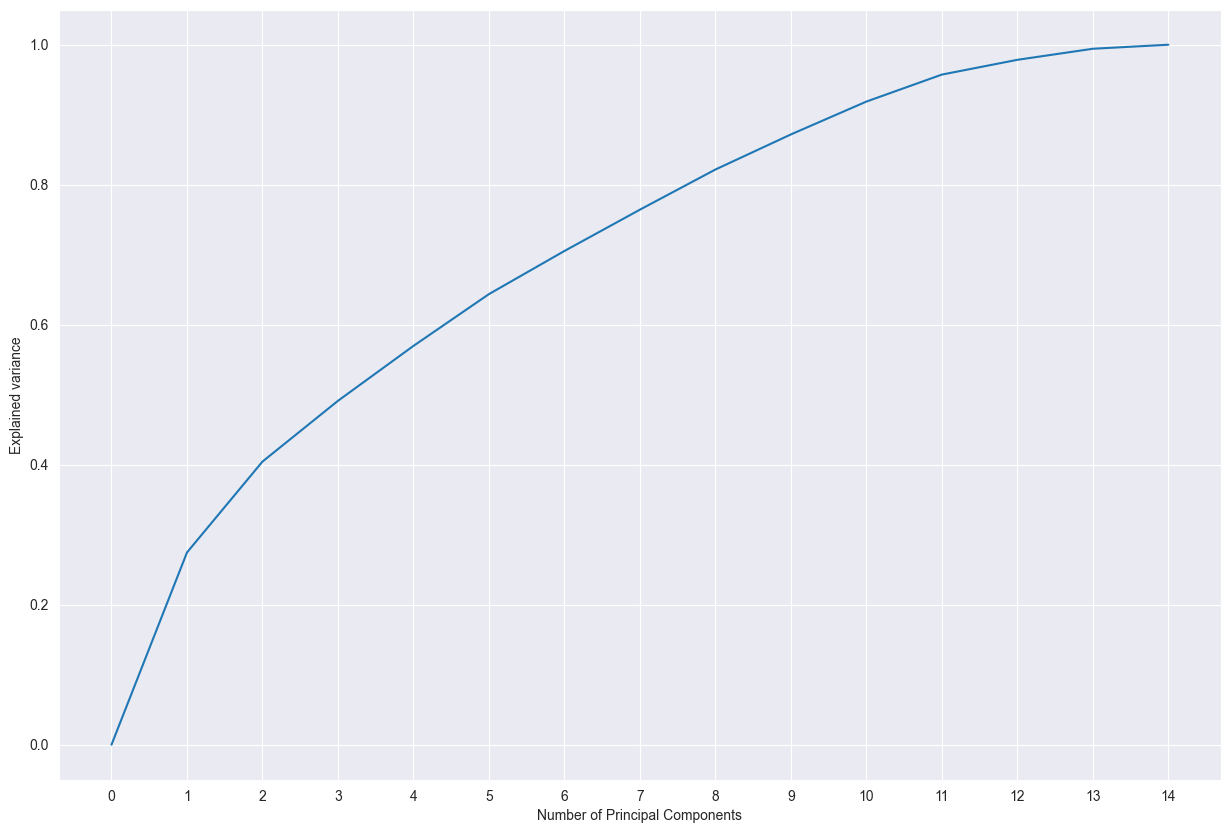

In [78]:
from sklearn import decomposition

pca=decomposition.PCA()
pca.fit(stand_feature_df)

# plot variance explained
v = pca.components_
explained_variance = pca.explained_variance_ratio_

# calculate cumulative explained variance. prepend 0 for variance with no components
y = list(np.cumsum(explained_variance))
y = [0] + y

# plot
plt.subplots(figsize=(15,10))
plt.plot(y);
plt.xlabel('Number of Principal Components')
plt.xticks(range(0,len(y)))
plt.ylabel('Explained variance');

Let's also print the exact amounts of 2, 4, 6 and 8 principal components to be accurate in our assessment.

In [79]:
print(f'2 Principal Components explain {np.round(y[2]*100, 2)}% of the variance')
print(f'4 Principal Components explain {np.round(y[4]*100, 2)}% of the variance')
print(f'6 Principal Components explain {np.round(y[6]*100, 2)}% of the variance')
print(f'8 Principal Components explain {np.round(y[8]*100, 2)}% of the variance')

2 Principal Components explain 40.45% of the variance
4 Principal Components explain 56.97% of the variance
6 Principal Components explain 70.53% of the variance
8 Principal Components explain 82.17% of the variance


Just two components can explain 40.45% of the variance, which is quite a lot considering we have 13 components in total. Four principal components explain 56.97% of the variance, and at around 8 principal components we begin to see the curve taper off, and we get little extra variance explained with additional components.

### 2.2.3 Plotting songs by genre
Let's use the two components as axes to plot our song data on. We can colour this by genre to identify whether the two principal components can identify whether there are any distinct characteristics of each genre.

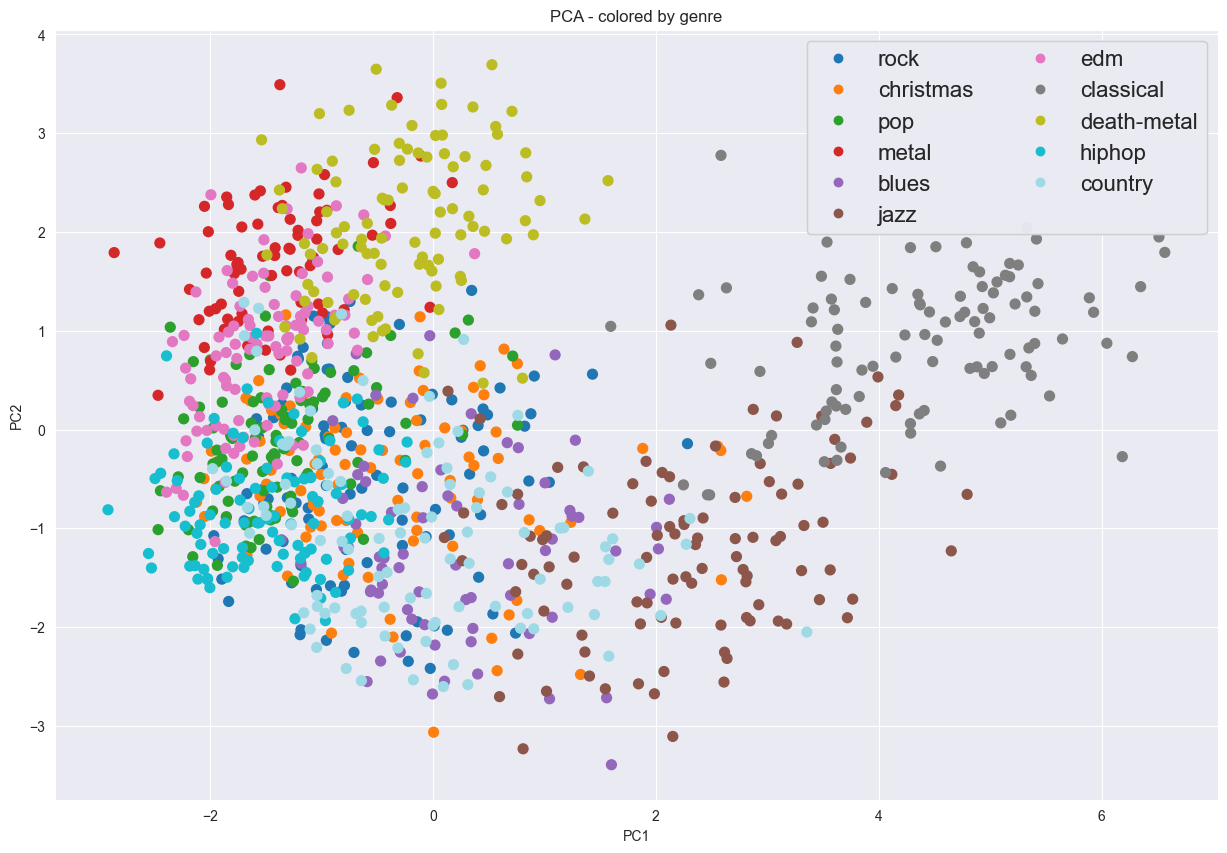

In [80]:
X_reduced=pca.transform(stand_feature_df)

coord1 = [x[0] for x in X_reduced] 
coord2 = [x[1] for x in X_reduced] 

fig, ax = plt.subplots(figsize=(15,10))

# colored by genre
color_column = 'genre'
colormap = dict(zip(track_df[color_column].unique(), range(1,100)))
scatter = ax.scatter(coord1, coord2, s=50 ,c=track_df[color_column].map(colormap), cmap='tab20')
legend1 = ax.legend(scatter.legend_elements()[0], colormap.keys(), loc="upper right", fontsize=16, ncols=2)
ax.add_artist(legend1)
ax.set_title(f"PCA - colored by {color_column}")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

Even just using 2 principal components to plot our data on, we clearly see some clusters taking shape. The genres classical and jazz are skewed towards the higher end of PC1, whereas death metal and metal, even edm is skewed towards the higher end of PC2. Judging from this, it would be reasonable to assume that PC1 captures features that are more related to the musical complexity of a song, like mode, key, time_signature and maybe even acousticness, liveness and instrumentalness (predicts whether a track contains no vocals, typical of classical and jazz). On the other hand, PC2 may explain more dynamic features like energy, loudness and tempo. These would be typical characteristics of genres like death metal and edm that are higher energy genres. We can see that pop, hiphop and edm are somewhat bundled together in the lower left corner, indicating feature similarities between the genres. Interestingly, the songs from the christmas genre is spread out across the plot. This perhaps what we would expect of a pseudo-genre like christmas, as christmas songs are written by many different artist across genres.

Again we refer to the Spotify documentation if you are interested in the definition and measurement of the audio features (https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features).

Through our Principal Component Analysis, we have now discovered that the features do in fact provide meaningful insight into our data. Furthermore, we were able to create principal components that aggregate the features into lesser dimensions, and even with two components we are able to capture over 40% of the variance, which was enough to see how genres relate to one another. The PCA will also come in handy as a visualization tool when making clusters in the following section. For now, we can include the audio features in our recommender system with good reason.

# 3. Clustering
When building a recommender system, we have to somehow group songs together based on their similarity of features. As we discovered in the PCA, there clearly are similarities within each genre, as they each occupied a unique location in the 2d space we created. However, as genres like death metal and classical seperated themselves quite clearly, other genres like pop and hiphop had much overlap. Even death metal and classical had overlaps with other genres. This informs us, that simply building a recommender system based on genre would ignore songs from other genres with very similar characterics. In the use case of our recommender system, we would also like the model to encourage listeners to explore other genres. Doing so by having songs recommended with similar features is a great way to start expanding their musical horizon.

Now, as we cannot recommend by genre, we need some other method to group songs with similar features together. To do this, we will use clustering. First, let's cluster the data using different methods and see which performs the best.

## 3.1 K-Means
K-means clustering aims to partition *n* observations into *k* clusters, where each observation is located in the cluster with the nearest mean, refered to as the cluster centroid.

K-means clustering works by choosing the number of clusters we want to identify, and then initializing the cluster centroids in the feature space. For each data point in the data set, the disnance to all centroids is calculated. The data point is assigned to the cluster that has the smallest distance to the cetroid. The centroids are recalculate by taking the mean of all the data points assigned to each cluster, and the assignments are updated. This is repeated until the algorithm converges to a set of k cluster centroids, and each data point is assigned to the cluster whose centroid it is closest to.

### 3.1.1 Choosing amount of principal components to cluster on
We have a few options when clustering. Firstly, we can choose to cluster on the full dataset, meaning all features. However, this can be problematic due to the "curse of dimensionality", where the performance of the clustering algorithms can be impacted negatively due to the high dimension size of 14 features. As K-means relies on Euclidean distance to form clusters, in high dimensional spaces, the distances can become less meaningful as all points tend to be equidistant from one another. A similar issue will occur with hierarchical clustering, while DBSCAN also will be negatively affected. Thus, the algorithms ability to define clear clusters is limited.

Secondly, we can cluster using the principal components from before. This way we avoid including too many dimensions, as we have projected all features into lesser dimensions. As we have 14 features, we will cluster on 8 principal components. As we recall from the PCA plot, this was enough to explain 82% of the variance in our data. From conducting research on the amount of components to select, we believe this is sufficient to provide meaningful reccomendations, while still avoiding "the curse of dimensionality". Furthermore, reducing the features to 8 components will be more computationally efficient for the clustering algorithms. It might not have much impact on this smaller subset of Spotify data, but if the solution is scaled to Spotify's entire muscial library it will be beneficial. We will make an additional comment on this in section 3.1.2.

Now let's perform the K-means clustering.

Sources:
- https://en.wikipedia.org/wiki/Curse_of_dimensionality
- https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d

In [81]:
# make a reduced df with 8 principal components
num_components = 8
df_8pc = pd.DataFrame(X_reduced,
                      columns=['PC' + str(i) for i in range(1, 15)]).drop(['PC' + str(i) for i in range(9, 15)], axis=1)

In [82]:
# number of clusters
n_clusters = 8

# fit the K-means algorithm to our PC components
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(df_8pc)

KMeans(n_init=10, random_state=42)

Here, we have fitted a model using 8 clusters. The following section will explain why.

### 3.1.2 Selecting optimal amount of clusters
When performing K-means clustering, one can utilize the Elbow method to identify the optimal amount of clusters. Here we select the cluster amount with the biggest change in slope in the curve. However, for our specific usecase, we know that some of the genres can be highly similar in terms of their features, and we want a bit more nuanced distinctions in the data. This method is useful for completely unlabeled data, but in our case, we already know that we have 11 different genres in the dataset, which themselves can be considered clusters. We therefore already have a rough estimate of what would be a reasonable amount of clusters. As we will see in the elbow plot below, the optimal amount according to the Elbow method is 3 clusters, but we will ignore this as we have the domain knowledge that justifies a selection of 8. 

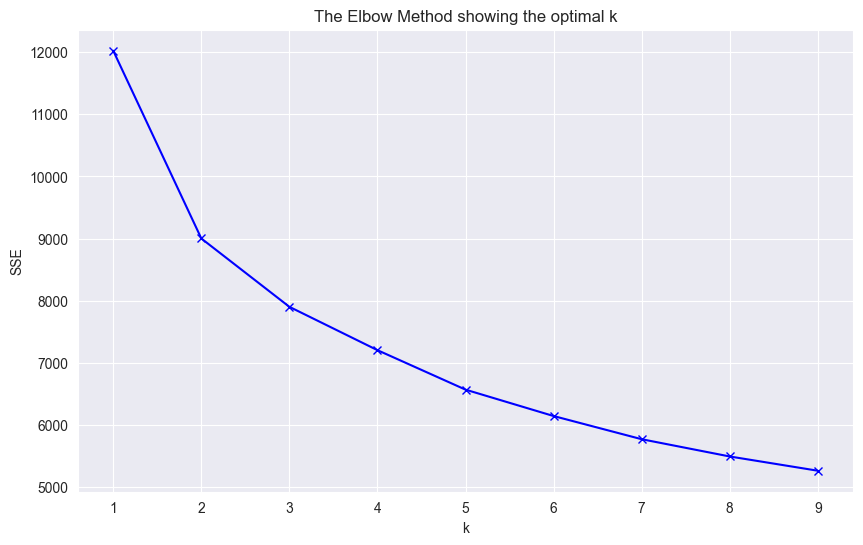

In [83]:
k_values = range(1, 10)

sse_values = []
for k in k_values:
   kmeans = KMeans(n_clusters=k, n_init=10)
   kmeans.fit(df_8pc)
   sse_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, sse_values, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Now we can use the model to assign the songs in our dataset to clusters.

In [84]:
# make a copy of original df and standardize its features
df_kmeans = track_df.copy()
df_kmeans[features] = pd.DataFrame(stand_scaler.fit_transform(track_df[features]), columns=features)

# assign each song to a cluster and store in a column
df_kmeans['cluster_label'] = kmeans.predict(df_8pc)

The songs have now been assigned to a cluster as seen below.

In [85]:
df_kmeans.drop(features, axis=1).head(5)

,track_name,artist_name,genre,cluster_label
0,I Wanna Be Sedated - 2002 Remaster,Ramones,rock,3
1,Highway to Hell,AC/DC,rock,0
2,"Paint It, Black",The Rolling Stones,rock,1
3,Everlong,Foo Fighters,rock,0
4,Free Bird,Lynyrd Skynyrd,rock,2


We then evaluate the k-means clustering method using the Davies-Bouldin index, as was presented in the week 6 lecture of the course.

In [86]:
from sklearn import metrics

k_means_score = metrics.davies_bouldin_score(df_8pc, df_kmeans['cluster_label'])
print(f'The Davies-Bouldin index for K-means clustering is: {k_means_score.round(3)}')

The Davies-Bouldin index for K-means clustering is: 1.577


We will use this same process for the following clustering methods and assess after all three has been conducted.

### 3.1.3 Final comment on number of components

Regarding the crucial balance between "the curse of dimensionality" and the amount of features to include (or in our case components), the plot below provides some additional context as to why 8 principal components were selected.

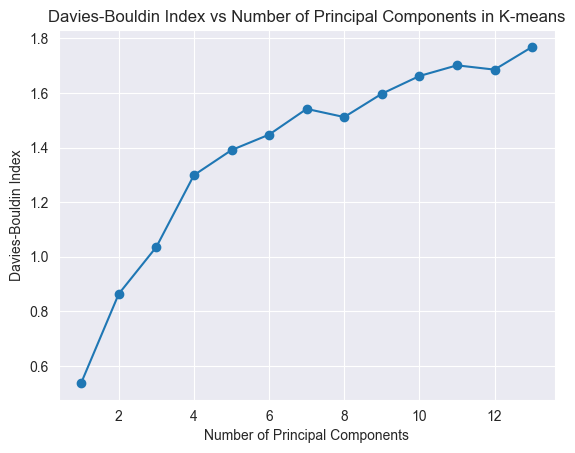

In [87]:
from sklearn.decomposition import PCA

# Range of the number of principal components
n_components_range = range(1, 14)

# Store Davies-Bouldin Index for each number of components
db_index_values = []

for n_components in n_components_range:
    # PCA
    pcaIndex = PCA(n_components=n_components) # change name for testing
    data_reduced = pcaIndex.fit_transform(X_reduced)
    
    # KMeans clustering
    n_clusters = 10  # number of genres
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data_reduced)
    
    # Davies-Bouldin Index
    db_index = metrics.davies_bouldin_score(data_reduced, clusters)
    db_index_values.append(db_index)

# Plotting the results
plt.plot(n_components_range, db_index_values, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Principal Components in K-means')
plt.show()


As we can see in the plot, the Davies-Bouldin index increases as we include more components in the K-means algorithm. However, as we look at different dimensions and therefore different configurations of our data, each set of principal components will represent a different view of our data. This will therefore affect the Davies-Bouldin score, as clusters become less compact and clearly seperated. Now, it would be "easy" to get a low Davies-Bouldin using only two components, but we would not be explaining much of the variance that additional components provide. Thus, this is where we must select a trade-off. As seen in the plot, the score increases up two 7 components, but then we see a slight dip in Davies-Bouldin at 8 components. This further supports our decision, that clustering on 8 components is a reasonable choice, given the context of our data.

### DBSCAN
Another approach to clustering is DBSCAN. DBSCAN is a density based clustering algorithm which means that it considers points connected if they are within a certain EPS value of each other and there are atleast a number of points within that distance. So, that it groups together points that are packed closely to each other and seperates those that are far away. It does so by having a couple of parameters defined. eps_value is the maximum distance between two points for them to be considered connected. Min_sample_value defines the minimum number of points required to create a cluster. Once the parameters are set, it creates a neighbourhood of points within the eps_value distance. If a point has atleast min_sample_value points in its neighborhood, it is considered a core point. Then starting from each core point, dbscan explands the clusters by adding all points within the eps_value distance that are in the neighborhood of the core point.

In [88]:
from sklearn.cluster import DBSCAN

# make a copy of original df and standardize its features
df_dbscan = track_df.copy()
df_dbscan[features] = pd.DataFrame(stand_scaler.fit_transform(track_df[features]), columns=features)

eps_value = 1.1
min_samples_value = 5
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
df_dbscan['cluster_label'] = dbscan.fit_predict(df_8pc)

In [89]:
dbscan_score = metrics.davies_bouldin_score(df_8pc, df_dbscan['cluster_label'])
print(f'The Davies-Bouldin index for DBSCAN clustering is: {dbscan_score.round(3)}')

The Davies-Bouldin index for DBSCAN clustering is: 1.717


### Hierarchical clustering
The final clustering method used is hierarchical clustering, more specifically Agglomorative clustering. This clustering method has a naive bottom up approach. First, each data point forms a cluster, then clusters close to one another are combined to a new one. The algorithm then stops this process once we reach our desired number of 8 clusters.

In [90]:
from sklearn.cluster import AgglomerativeClustering

# make a copy of original df and standardize its features
df_agg = track_df.copy()
df_agg[features] = pd.DataFrame(stand_scaler.fit_transform(track_df[features]), columns=features)

agglomorative = AgglomerativeClustering(n_clusters = 8)
df_agg['cluster_label'] = agglomorative.fit_predict(df_8pc)

In [91]:
agglomorative_score = metrics.davies_bouldin_score(df_8pc, df_agg['cluster_label'])
print(f'The Davies-Bouldin index for Agglomorative clustering is: {agglomorative_score.round(3)}')

The Davies-Bouldin index for Agglomorative clustering is: 1.706


### Evalutation
Now we can compare the cluster methods in terms of their Davies-Bouldin index.

In [92]:
scores = [k_means_score.round(4), dbscan_score.round(4), agglomorative_score.round(4)]
cluster_methods = ['K-Means', 'DBSCAN', 'Hierarchical']
eval_df = pd.DataFrame(scores, columns=['score'], index=cluster_methods)
eval_df.index.rename('cluster', inplace=True)
eval_df

,score
cluster,
K-Means,1.5769
DBSCAN,1.7168
Hierarchical,1.7062


K_Means is clearly the winner with a Davies-Bouldin index of 1.5755. Let's visualize the clusters performed by this algorithm on our two-dimensional PC axes from earlier.

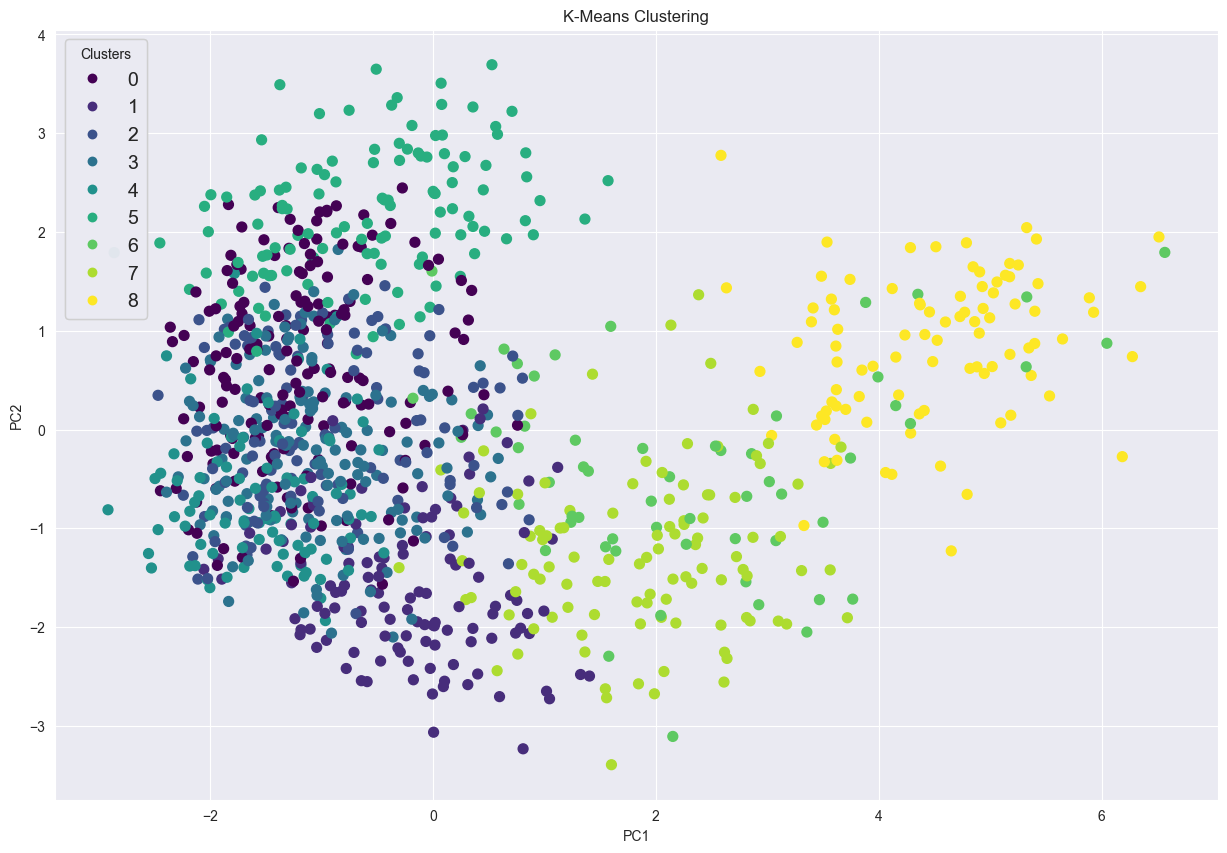

In [93]:
fig, ax = plt.subplots(figsize=(15, 10))

# colored by cluster
scatter = ax.scatter(coord1, coord2, s=50, c=df_kmeans['cluster_label'], cmap='viridis', marker='o')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper left", fontsize=14)
ax.add_artist(legend1)
ax.set_title(f"K-Means Clustering")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.show()

In this two-dimensional visual representation of the clusters, we can see how the K-means algorithm has clustered the data. As the song data has been clustered using 8 dimensions, we can see how there is overlap among the clusters in our two-dimensional plot. Had we just clustered using two principal components, we would have missed a lot of the intricacies leading to this.

If we compare with our two-dimensional PCA plot labeled by genre, we can actually see some similarities. In example, the K-means clustering seem to have identified very similar "clusters" as we saw with the labeled jazz and classical clusters. Although we would not necessarily want the algorithm to cluster them into the genres we saw, it is a good indicator that the clustering has managed to divide the data in a way where the features/principal components are represented in a meaningful way.

Making a qualitative visual assesment of the clusters like this, further supports our decision of selecting K-means, rather than by solely judging from the Davies-Bouldin index.

# 4. Recommendation system

The first recommendation system looks at the song features and makes a prediction on where a song would be placed in the cluster space. From the cluster space the distance to the nearest node can be calculated, hereby calculating the most similar song (the one with the shortest distance).

Our input for the reccomendation is a random sample of our entire song library. This would represent a playlist made by a Spotify user. For each song in that playlist the recommendation system recommends two songs based on the song's features.

The input playlist goes through the same procedure as the complete song dataset, which includes standardization and PCA analysis. KMeans clustering is then performed on the principal components. K-nearest neighbors is then used to find recommendations for each song based on their proximity in the reduced space. The indices and distances of the recommended songs are printed for each original song in the dataset.

In [94]:
tp = track_df.sample(n=20)
tp_tpaf = tp[features]

In [95]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

stand_scaler = StandardScaler()
standardized_tp_tpaf = stand_scaler.fit_transform(tp_tpaf)

pcaTest = decomposition.PCA(n_components=num_components)
pcaTest.fit(standardized_tp_tpaf)
tp_reduced = pcaTest.transform(standardized_tp_tpaf)

# Create DataFrame with principal components
columns = [f'PC{i}' for i in range(1, num_components + 1)]
tp_reduced_test = pd.DataFrame(tp_reduced, columns=columns)

# KMeans clustering
numberOfClusters = 8
kmeans = KMeans(n_clusters=numberOfClusters, random_state=42, n_init=8)
tp_reduced_test['tp_cluster'] = kmeans.fit_predict(tp_reduced_test.iloc[:, :num_components])


# fit dataset into Nearest Neighbors
neigh = NearestNeighbors(n_neighbors = 2) # change for the amount of recomendations for each song
neigh.fit(df_8pc.iloc[:, :num_components])  # Use the same features used for clustering

# Perform k-nearest neighbor on tp_reduced
distances, indices = neigh.kneighbors(tp_reduced_test.iloc[:, :num_components])

# Print the indices of closest songs in df_af
print("Indices of recommended songs:", indices)

# result
for i, index in enumerate(indices):
    print(f"\n Recommendations for the song: {tp.iloc[i]['track_name']} by {tp.iloc[i]['artist_name']}: ")
    for j, song_index in enumerate(index):
        print(f"{j + 1}. Song: {track_df.iloc[song_index]['track_name']} by {tp.iloc[i]['artist_name']} with Eucledian Distance: {distances[i][j].round(3)}")

Indices of recommended songs: [[ 669  670]
 [ 601  623]
 [ 163  956]
 [ 686  679]
 [ 414  192]
 [  10  393]
 [  26 1005]
 [ 217  583]
 [ 217  291]
 [ 173  150]
 [ 125   60]
 [ 128  158]
 [ 659  739]
 [ 891  897]
 [ 988  982]
 [ 613  611]
 [ 216  285]
 [ 445  517]
 [ 198  590]
 [ 205  631]]

 Recommendations for the song: Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio by Wolfgang Amadeus Mozart: 
1. Song: Piano Concerto in A Minor, Op. 16: I. Allegro molto moderato by Wolfgang Amadeus Mozart with Eucledian Distance: 1.964
2. Song: Piano Concerto in A Minor, Op. 16: I. Allegro molto moderato by Wolfgang Amadeus Mozart with Eucledian Distance: 2.034

 Recommendations for the song: TAKE IT OFF by FISHER: 
1. Song: Ecstasy by FISHER with Eucledian Distance: 2.079
2. Song: Be My Lover (feat. La Bouche) - 2023 Mix by FISHER with Eucledian Distance: 2.166

 Recommendations for the song: Africa by TOTO: 
1. Song: Vi lover hinanden by TOTO with Eucledian Distance: 1.731
2. Song: Pancho

## 4.1 Lyrical recommendation system
### Data retrieval

In [96]:
import requests
import lyricsgenius as lg
from lyricsgenius import Genius

ModuleNotFoundError: No module named 'lyricsgenius'

In [97]:
api_key = "qKCW6OXZe35kgBNTzi8rMS3yw47RvkM2FMJAVMUDpm_JLKDbEv77TLRTbbSPY0oL"

genius = lg.Genius(api_key, timeout=100, skip_non_songs=True, excluded_terms=["(Live)"], remove_section_headers=True)

NameError: name 'lg' is not defined

### Data cleaning

## 4.2 Genius data collection

In [98]:
def clean_title(song_title):

    exclusion_terms = ["(feat.", "(ft.", "-"]

    # Clean "(feat."
    for term in exclusion_terms:
        if term in song_title:
            song_title = song_title.split(term)[0].strip()
    return song_title

In [99]:
def get_lyrics(df, song_col, artist_col):

    all_lyrics = {}
    success_count = 0

    for index, row in df.iterrows():
        song = clean_title(row[song_col])
        artist = row[artist_col]
        song_lyrics = genius.search_song(song, artist)
        
        # Check if lyrics are found and add to all_lyrics and increase success_count
        # if not do not increase success_count
        if song_lyrics:
            if song_lyrics.title == row[song_col]:  
                all_lyrics[song] = song_lyrics.lyrics
                success_count += 1
        else:
            success_count += 0

    # Return the lyrics and the number of successful downloads
    return all_lyrics, print(f"Successfully downloaded {success_count} out of {len(df)} songs")

In [100]:
# UNCOMMET IF YOU WANT TO SCRAPE DATA MANUALLY, OTHERWISE GO TO NEXT BLOCK
# df_merge_lyrics = get_lyrics(df_merge, 'track_name', 'artist_name')

In [101]:
# Save locally and import


# 4.3 Lyrical recommendation system
The dataset of song lyrics is loaded and read. The initial operation creates a dictionary that maps song names to their corresponding lyrics. Afterwards, the text undergoes preprocessing, involving the removal of newline characters, splitting at spaces, converting to lowercase, and discarding non-alphanumeric symbols. Following this, the code generates q-shingles (subsequences of length q) from the cleaned text and utilizes a minhashing algorithm to produce a signature matrix. Jaccard similarity is computed between pairs of songs based on their signatures, identifying similar songs surpassing a specified threshold. This however has been computed beforehand due to the time it takes to calculate. This signature matrix is loaded from a file instead and loaded as a multidimensional numpy array. The final DataFrame (df_lyric_result) contains pairs of songs and their corresponding similarity scores, suggesting potential song similarities based on their lyrics.

In [102]:
lyrics = pd.read_csv("lyrics")
song_lyrics = dict(zip(lyrics['song'], lyrics['lyrics']))

# hashes a list of strings

def listhash(l, seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val


def clean_text(string):
    output = string.replace('\n', '')
    outputs = output.split()
    outputs = list(map(lambda word: ''.join(char.lower() for char in word if char.isalnum()), outputs))
    outputs = list(map(str.lower, outputs))
    output = ' '.join(outputs)
    return ' '.join(output.split())


q = 2 
k = 20000 
docs = song_lyrics
for key in list(docs.keys()):
    docs[key] = clean_text(docs[key])


def shingle(string, q):
    shingles = []
    words_list = string.split(delimiter)
    for i in range(len(words_list) - q + 1):
        shingles.append(delimiter.join(words_list[i : i + q]))
    return list(set(shingles))


def better_minhash(shingle, k):
    all_minhash = []
    for i in range(k):
        all_minhash.append(mmh3.hash(shingle, i))
    return all_minhash


def better_sig(document):
    sig_matrix = np.zeros((len(document.keys()), k))
    all_shingles = []
    all_shingles_dict = {}
    count = 0
    for i, e in enumerate(document.values()):
        all_shingles_dict[i] = set(shingle(e, q))
        all_shingles.extend(shingle(e, q))
    all_shingles_dict_size = len(all_shingles_dict.keys())
    all_shingles = set(all_shingles)
    all_shingles_size = len(all_shingles)
    for s in all_shingles:
        minhash = better_minhash(s, k)
        for i in range(all_shingles_dict_size):
            if s in all_shingles_dict[i]:
                for j in range(k):
                    if sig_matrix[i][j] > minhash[j]:
                        sig_matrix[i][j] = minhash[j]
        count += 1
        if count % 1000 == 0:
            print(f'{count} / {all_shingles_size}')
    return sig_matrix

def jaccard(doc1, doc2, docs):
    sig1 = np.array(docs[doc1])
    sig2 = np.array(docs[doc2])

    intersect = np.intersect1d(sig1, sig2)
    return len(intersect) / len(np.union1d(sig1, sig2))


def similar(signatures, songlist, threshold):
    sig_keys = list(signatures.keys())
    similar = {}
    for i in range(len(sig_keys) - 1):
        for j in range(len(songlist)):
            score = jaccard(sig_keys[i], songlist[j], signatures)
            if score > threshold:
                similar[(sig_keys[i], songlist[j])] = score

    return similar

input_sigs = []
for ind in tp.index:
    if tp['track_name'][ind] in docs:
        input_sigs.append(tp['track_name'][ind])


In [103]:
## UNCOMMENT TO CREATE SIGNATURE MATRIX.
#better_sig_matrix = better_sig(docs)
#np.save('signature_matrix-q2k20000.npy', better_sig_matrix)

In [ ]:

sig_matrix = np.load("signature_matrix-q2k20000.npy")
sig_matrix
new_algo_sig = {
    row_key: sig_matrix[i, :].tolist()
    for i, row_key in enumerate(docs.keys())
}
print(new_algo_sig)

result = similar(new_algo_sig, input_sigs, 0.01)

df_lyric_result = pd.DataFrame(list(result.items()), columns=['Songs', 'Eval'])

#Split the 'Tuple' column into two separate columns
df_lyric_result[['Song1', 'Song2']] = pd.DataFrame(df_lyric_result['Songs'].tolist(), index=df_lyric_result.index)

# Drop the original 'Tuple' column
df_lyric_result = df_lyric_result.drop(columns=['Songs'])
# Removes songs that have been compared to themselves, resulting in a evaluation of 1
df_lyric_result = df_lyric_result[df_lyric_result.Eval != 1]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Combined results

The end result, consists of a list of songs and their recommendations based on their audio features and their lyrics

In [72]:

df_lyric_result.drop(columns=["Eval"])
df_lyric_result

for i, index in enumerate(indices):
    print(f"\nRecommendations for Song {tp.iloc[i]['track_name']}:")
    print(f"\nBy features:")
    for j, song_index in enumerate(index):
        print(f"{j + 1}. Song: {track_df.iloc[song_index]['track_name']} by {track_df.iloc[song_index]['artist_name']}")

    # Filter result_df for the current song
    song_recommendations = df_lyric_result[df_lyric_result['Song2'] == tp.iloc[i]['track_name']]
    song_recommendations = song_recommendations.nlargest(2, "Eval")
    if not song_recommendations.empty:
        print(f"\nBy lyrics:")
        j = 0
        for _, row in song_recommendations.iterrows():
            artist = track_df[track_df['track_name'] == row['Song1']].iloc[0]['artist_name']
            print(f"{j + 1}. Song: {row['Song1']} by {artist}")
            j += 1


Recommendations for Song The Summoning:

By features:
1. Song: Jaded by Spiritbox
2. Song: Nobody by Avenged Sevenfold

By lyrics:
1. Song: Paint It, Black by The Rolling Stones
2. Song: I Believe by Jonas Brothers

Recommendations for Song Moonshield:

By features:
1. Song: Calling by Hannah Wants
2. Song: Ray Of Solar - Tiësto Remix by Swedish House Mafia

By lyrics:
1. Song: Meet Your Maker by In Flames
2. Song: Artifacts of the Black Rain by In Flames

Recommendations for Song Cheek To Cheek:

By features:
1. Song: Dream A Little Dream Of Me - Single Version by Ella Fitzgerald
2. Song: Feels Like Rain (feat. Bonnie Raitt) by Buddy Guy

By lyrics:
1. Song: Embraceable You by Sarah Vaughan
2. Song: I Can Feel by Leony

Recommendations for Song Amarillo By Morning:

By features:
1. Song: Fly Me To The Moon by Astrud Gilberto
2. Song: A Pirate Looks At Forty by Jimmy Buffett

By lyrics:
1. Song: The Fireman by George Strait
2. Song: Girls, Girls, Girls by Mötley Crüe

Recommendations 